In [271]:
import networkx as nx
import pandas as pd
import math
import tqdm
import matplotlib.pyplot as plt 
import numpy as np
from collections import deque
import random
from scipy import stats

In [168]:
df = pd.read_csv('twitter_small_data.csv')
df = df.drop(['Unnamed: 0'], axis=1)
df.head()

,node1,node2
0,253601,1
1,20980,2
2,46231,3
3,154918,4
4,26370,5


In [169]:
G = nx.from_pandas_edgelist(df.iloc[:], source = 'node1', target = 'node2', create_using=nx.DiGraph())

In [185]:
Grev = G.reverse()

In [499]:
# NEW IMPLEMENTATION USING DYNAMIC PROGRAMMING
# CAN DO VERY HIGH VALUES OF K NOW
# Memory: O(k*len(G))
def new_centrality(G, gamma = 0.10, k=2, u = None, rev = False):
    '''
    G: directed graph G
    gamma: discount factor
    k: degree of depth of our search (not recommended to do >3)
    u: return for only a specific set of nodes (example below)
    '''
    s = 1.0 / (len(G) - 1.0)
    if not rev:
        G = G.reverse()  # create a reversed graph view
    if u is None:
        nodes = list(G.nodes)
    else:
        nodes = u
    centrality_dict = {}
    helper = {}
    for n in tqdm.tqdm(nodes):
        centrality_dict[n] = s*new_centrality_helper(G, n, helper, gamma=gamma, k=k, curr_depth = 0)
        if n in helper:
            helper[n][k] = centrality_dict[n] 
        else:
            helper[n] = {k: centrality_dict[n]}
    if not rev:
        G = G.reverse()
    return centrality_dict

def new_centrality_helper(G, n, helper_dict, gamma = 0.10, k=2, curr_depth = 0):
    if n in helper_dict: 
        if curr_depth in helper_dict[n]:
            return helper_dict[n][curr_depth]
    if (curr_depth > k):
        return 0
    centrality = 0;
    for neighbor in G.neighbors(n):
        centrality += new_centrality_helper(G, neighbor, helper_dict, gamma, k, curr_depth + 1)
    if n in helper_dict:
        helper_dict[n][curr_depth] = math.exp(-gamma * curr_depth) + centrality
    else:
        helper_dict[n] = {curr_depth: math.exp(-gamma * curr_depth) + centrality}
    return math.exp(-gamma * curr_depth) + centrality

## Functions to produce the layer network graphs

In [411]:
def get_subgraph(G, node, k=2):
    G = G.reverse()
    q = deque() # queue of nodes
    nodelist = []
    q.append(node)
    for _ in tqdm.tqdm(range(k+1)):
        length = len(q)
        for __ in range(length):
            curr = q.popleft()
            for n in G.neighbors(curr): q.append(n)
            nodelist.append(curr)
    H=nx.subgraph(G, nodelist)
    G = G.reverse()
    return H

In [412]:
def get_color_map(H, n):
    color_map = []
    for node in H:
        if node != n:
            color_map.append('lightblue')
        else: 
            color_map.append('red')
    return color_map

In [413]:
def get_layout(H, n, k):
    pos = {}
    degs = [0]*k
    for node in H:
        theta = random.uniform(0, 360)
        l = nx.shortest_path_length(H, n, node)
        degs[l-1]+=1
        pos[node] = np.array([l * (math.cos(theta)), l * math.sin(theta)])
        
    textstr = f"Layer graph for node {n}"
    for i in range(len(degs)):
        #if (i!=0): textstr+='\n'
        textstr += f'\ndegree-{i+1} friends: {degs[i]}'
    
    return pos, textstr

In [414]:
def make_plot(G, n, k=2):
    H = get_subgraph(G, n, k)
    pos, textstr = get_layout(H, n, k)
    color_map = get_color_map(H, n)
    fig, axe = plt.subplots(figsize=(16,10))

    
    nx.draw(H.reverse(), pos, ax = axe, with_labels=False, node_color=color_map, 
            font_weight='light', node_size=50, width=0.1, arrowsize=8)
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

    # place a text box in upper left in axes coords
    axe.text(0, 0.85, textstr, transform=ax.transAxes, fontsize=14,
            verticalalignment='top', bbox=props)
    
    plt.show()

## Testing functions on typical node

100%|██████████| 3/3 [00:00<00:00, 573.93it/s]


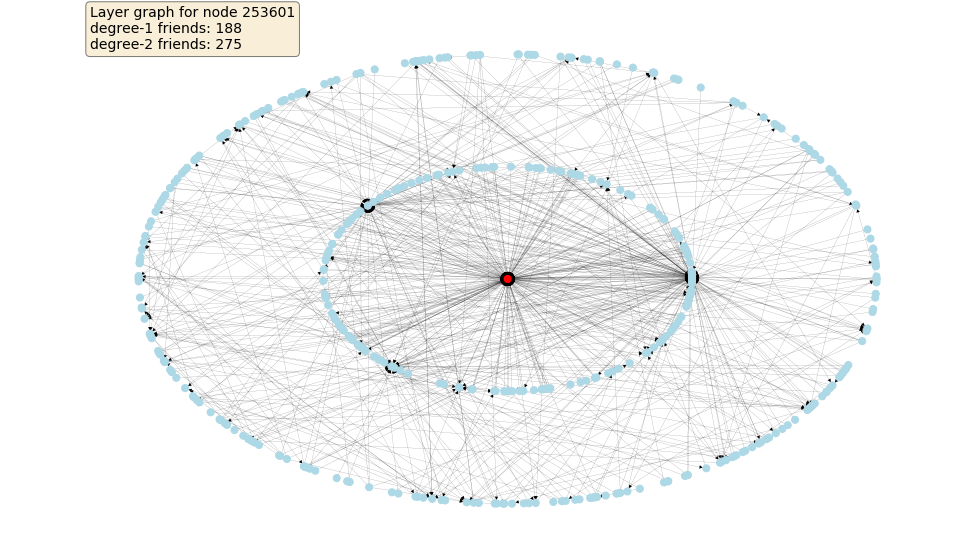

In [415]:
make_plot(G, 253601, k=2)

100%|██████████| 4/4 [00:00<00:00, 911.95it/s]


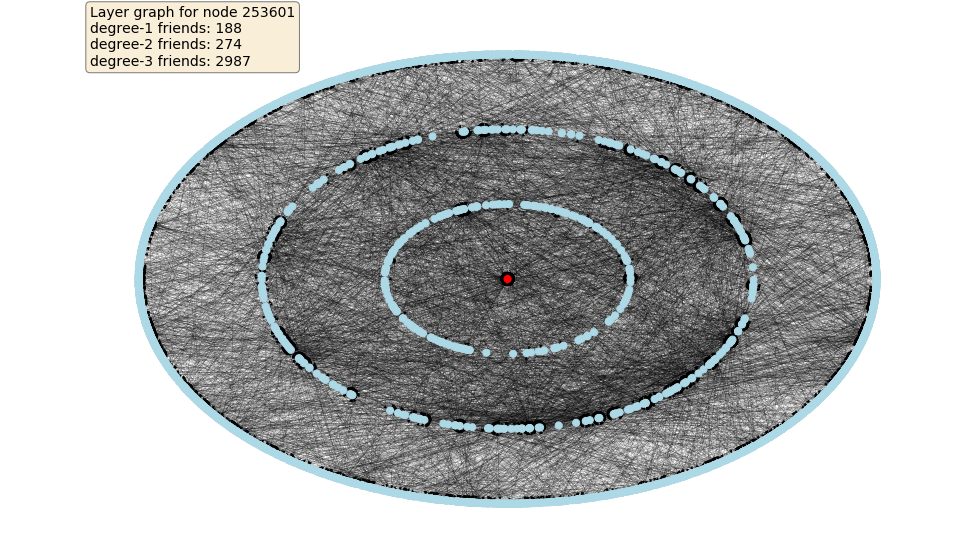

In [518]:
make_plot(G, 253601, k=3)

In [416]:
df_new = pd.read_csv('centralities.csv')

In [418]:
df_new.head()

,Unnamed: 0,k=2 centrality,k=3 centrality,pagerank,degree_centrality,closeness_centrality
0,0,0.000286,0.000921,0.000002,0.000002,0.006794
1,1,0.000620,0.001890,0.000012,0.000002,0.054225
2,2,0.000174,0.002353,0.000009,0.000002,0.050009
3,3,0.000446,0.002919,0.000002,0.000002,0.033050
4,4,0.000656,0.001988,0.000021,0.000002,0.055631


Text(0, 0.5, 'k=2 centrality')

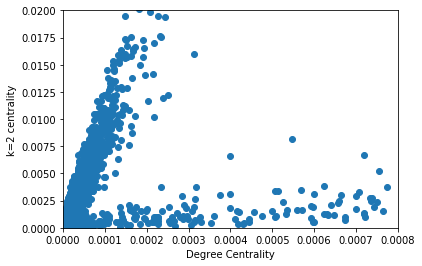

In [419]:
plt.scatter(df_new["degree_centrality"][:100000], df_new["k=2 centrality"][:100000])
plt.xlim((0, 8e-4))
plt.ylim((0, 20e-3))
plt.xlabel("Degree Centrality")
plt.ylabel("k=2 centrality")

Text(0, 0.5, 'k=2 centrality')

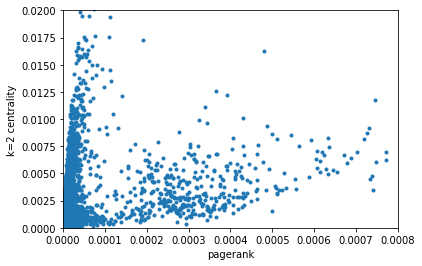

In [420]:
plt.scatter(df_new["pagerank"][:100000], df_new["k=2 centrality"][:100000], marker=".")
plt.xlim((0, 8e-4))
plt.ylim((0, 20e-3))
plt.xlabel("pagerank")
plt.ylabel("k=2 centrality")

### Find nodes with a high k=2 centrality but a low pagerank

In [525]:
def get_outliers(df):
    outliers = []
    for index, row in df[:100000].iterrows():
        if row["k=2 centrality"]/row["pagerank"] > 150 and row["k=2 centrality"]>0.0025: 
            outliers.append(row["Unnamed: 0"])
    return outliers

In [526]:
outliers = get_outliers(df_new)

In [528]:
# Note that this is 0-indexed, so the actual node is the outputted value + 1
outliers[0]

48.0

### Analysis on nodes with high k=2 centrality and low pagerank

In [266]:
# Find the followers of node 49
list(Grev[outliers[0]+1])

[44599, 63125, 83489, 127522, 239534, 243979, 259623, 299017, 326217]

Get information about the followers of node 49

In [298]:
neighborlist = list(Grev[outliers[0]+1])
for n in neighborlist:
    print(f"node {n}: pagerank: {df_new.loc[n-1]['pagerank']} " + 
          f"({stats.percentileofscore(df_new['pagerank'], df_new.loc[n-1]['pagerank'], 'strict')}) " + 
          f"k=2 centrality: {df_new.loc[n-1]['k=2 centrality']} " + 
          f"({stats.percentileofscore(df_new['k=2 centrality'], df_new.loc[n-1]['k=2 centrality'], 'strict')} " +
          f"num following: {len(list(G[n]))}" )
    # print(df_new.loc[n-1])
    

node 44599: pagerank: 0.00031721554763566384 (99.95774846251349) k=2 centrality: 0.006178284666971133 (99.87621040771498 num following: 54
node 63125: pagerank: 0.0002255343794283938 (99.91895611523057) k=2 centrality: 0.005361085643242471 (99.82951133996674 num following: 71
node 83489: pagerank: 0.00015970614568438618 (99.86953911232239) k=2 centrality: 0.007200266350083264 (99.91401441493974 num following: 73
node 127522: pagerank: 0.00011423751352085791 (99.82012210941419) k=2 centrality: 0.0037819518395622656 (99.67557737590774 num following: 139
node 239534: pagerank: 3.9815153068110606e-05 (99.6054052317781) k=2 centrality: 0.0019346214617648454 (99.0563823294681 num following: 226
node 243979: pagerank: 3.4115430341998745e-05 (99.56414203434976) k=2 centrality: 0.002130758369548899 (99.17251228630235 num following: 260
node 259623: pagerank: 8.635983377480593e-05 (99.77119927653507) k=2 centrality: 0.0007755530500336236 (96.33054044905231 num following: 299
node 299017: pageran

Plot of atypical nodes vs their followers

In [309]:
pr = []
k2 = []
colors = []
for outlier in outliers:
    pr.append(df_new.loc[outlier]['pagerank'])
    k2.append(df_new.loc[outlier]['k=2 centrality'])
    colors.append('red')
    neighborlist = list(Grev[outlier+1])

    for n in neighborlist:
        pr.append(df_new.loc[n-1]['pagerank'])
        k2.append(df_new.loc[n-1]['k=2 centrality'])
        colors.append('blue')

Text(0, 0.5, 'k=2 centrality')

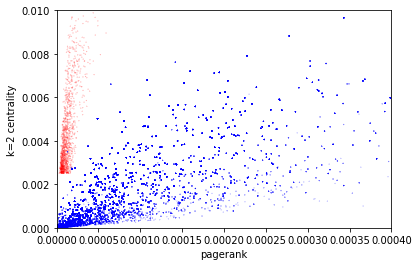

In [318]:
plt.scatter(pr, k2, c=colors, marker='.', s=0.05)
plt.xlim((0, 4e-4))
plt.ylim((0, 10e-3))
plt.xlabel("pagerank")
plt.ylabel("k=2 centrality")

Average k=2 centrality/pagerank ratio

In [325]:
np.mean(df_new['k=2 centrality']/df_new['pagerank'])

69.27450712160223

Example for just node 49

In [305]:
pr = []
k2 = []
colors = []
pr.append(df_new.loc[48]['pagerank'])
k2.append(df_new.loc[48]['k=2 centrality'])
colors.append('red')
neighborlist = list(Grev[outliers[0]+1])

for n in neighborlist:
    pr.append(df_new.loc[n-1]['pagerank'])
    k2.append(df_new.loc[n-1]['k=2 centrality'])
    colors.append('blue')

(0, 0.01)

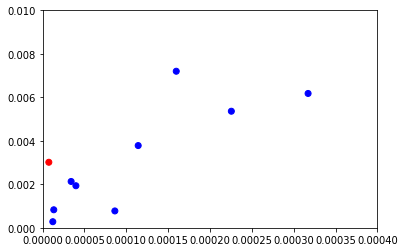

In [306]:
plt.scatter(pr, k2, c=colors)
plt.xlim((0, 4e-4))
plt.ylim((0, 10e-3))

Make a three-layer plot for node 49. Note very sparse deg-1 friends but a ton of layer 2 and 3 friends

100%|██████████| 4/4 [00:00<00:00, 34.40it/s]


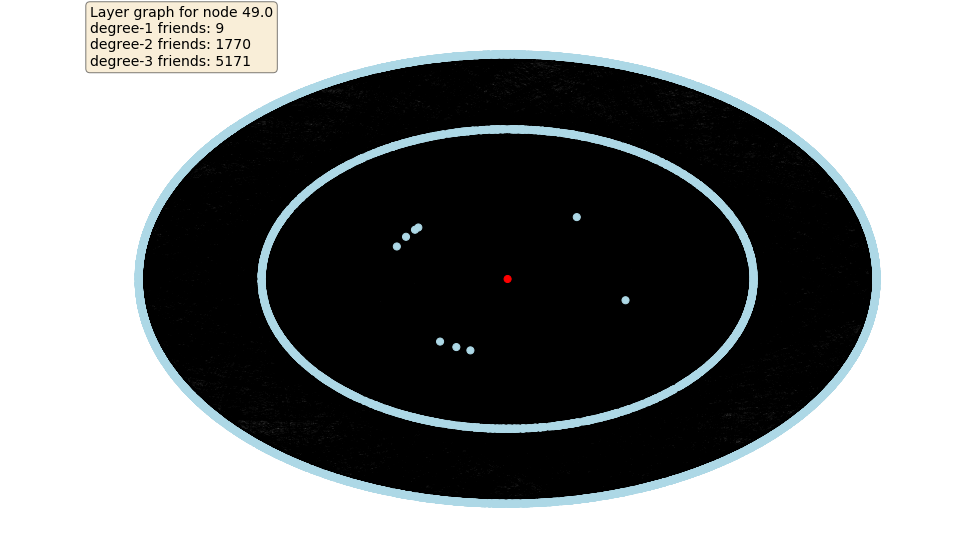

In [258]:
make_plot(G, outliers[0]+1, k=3)

Make a three-layer plot for node 49. Note very sparse deg-1 friends but a ton of layer 2 friends

100%|██████████| 3/3 [00:00<00:00, 1105.41it/s]


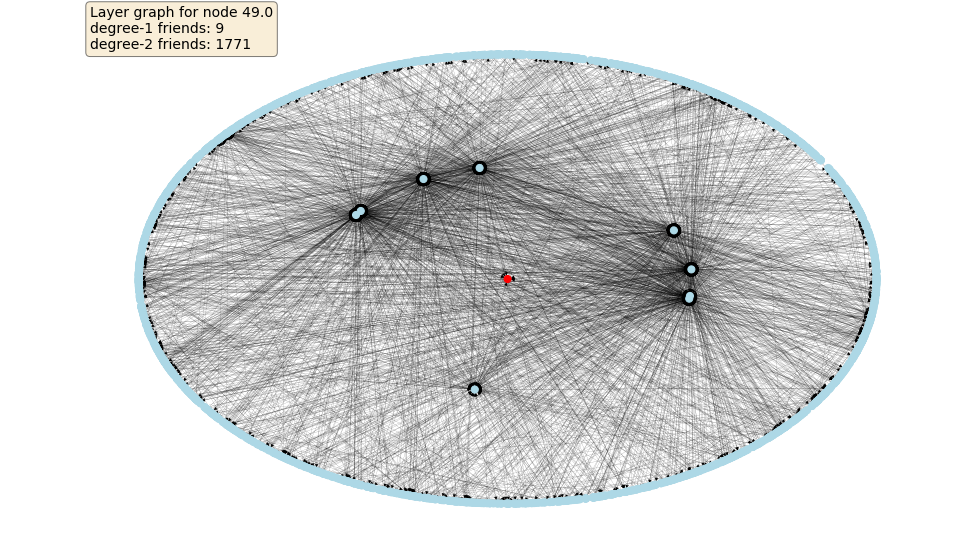

In [517]:
make_plot(G, outliers[0]+1, k=2)

Make a three-layer plot for node 162. Note very sparse deg-1 friends but a ton of layer 2 and 3 friends

100%|██████████| 4/4 [00:00<00:00, 45.47it/s]


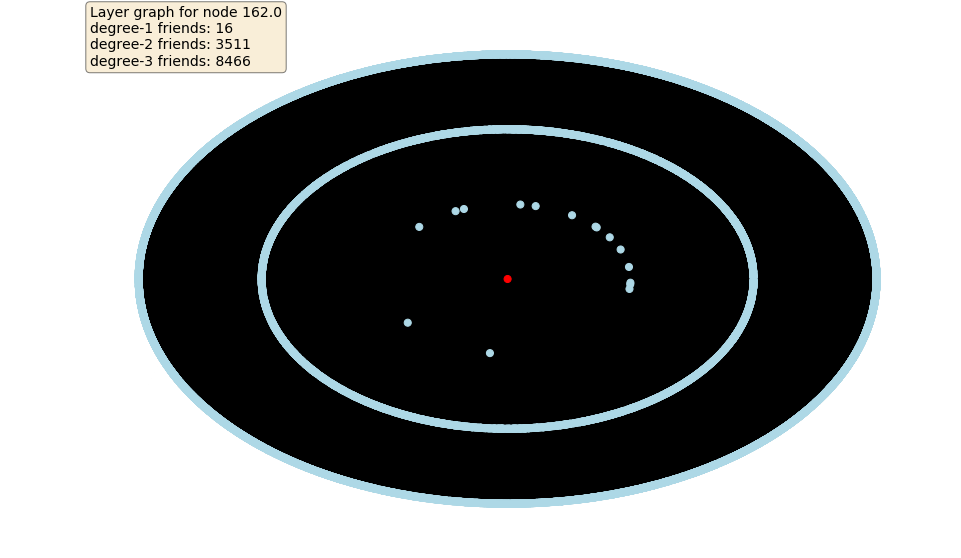

In [259]:
make_plot(G, outliers[1]+1, k=3)

# Compare our algorithm vs. PageRank for different values of k

In [514]:
k_centralities = []
Grev = G.reverse()
for i in range(10):
    k_centralities.append(np.array(sorted(new_centrality(Grev, k=i, rev=True).items()))[:,1])

100%|██████████| 404719/404719 [00:03<00:00, 124205.30it/s]


Assert equal lengths

In [436]:
len(df_new["pagerank"]), len(k_centralities[-1])

(404719, 404719)

Text(0, 0.5, 'k=1 centrality (i.e. degree centrality)')

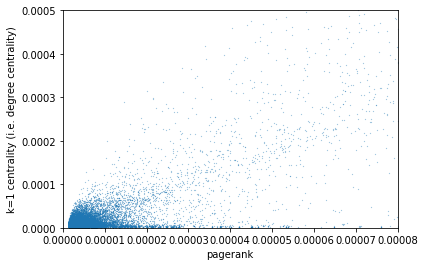

In [454]:
plt.scatter(df_new["pagerank"], 
            k_centralities[1],
            marker=".", s=0.1)

plt.xlim((0, .0012/15))
plt.ylim((0, 5e-4))
plt.xlabel("pagerank")
plt.ylabel("k=1 centrality (i.e. degree centrality)")

Text(0, 0.5, 'k=2 centrality')

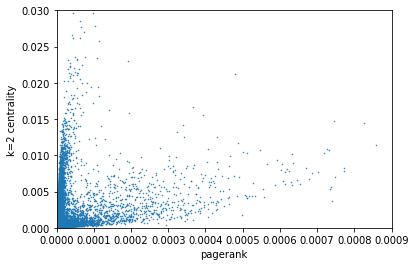

In [506]:
plt.scatter(df_new["pagerank"], 
            k_centralities[2],
            marker=".", s=1)

plt.xlim((1e-7, 9e-4))
plt.ylim((0, .03))
plt.xlabel("pagerank")
plt.ylabel("k=2 centrality")

Text(0, 0.5, 'k=3 centrality')

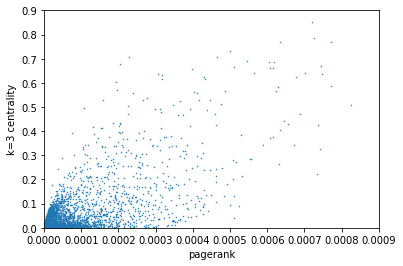

In [510]:
plt.scatter(df_new["pagerank"], 
            k_centralities[3],
            marker=".", s=1)

plt.xlim((1e-7, 9e-4))
plt.ylim((0, .9))
plt.xlabel("pagerank")
plt.ylabel("k=3 centrality")

Text(0, 0.5, 'k=4 centrality')

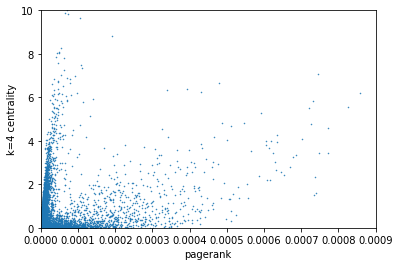

In [511]:
plt.scatter(df_new["pagerank"], 
            k_centralities[4],
            marker=".", s=1)

plt.xlim((1e-7, 9e-4))
plt.ylim((0, 10))
plt.xlabel("pagerank")
plt.ylabel("k=4 centrality")

Text(0, 0.5, 'k=5 centrality')

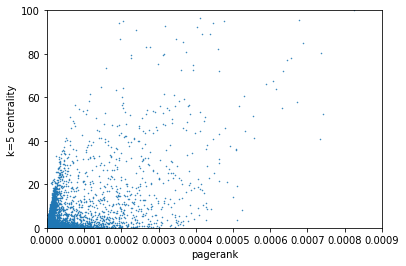

In [512]:
plt.scatter(df_new["pagerank"], 
            k_centralities[5],
            marker=".", s=1)

plt.xlim((1e-7, 9e-4))
plt.ylim((0, 100))
plt.xlabel("pagerank")
plt.ylabel("k=5 centrality")

Text(0, 0.5, 'k=6 centrality')

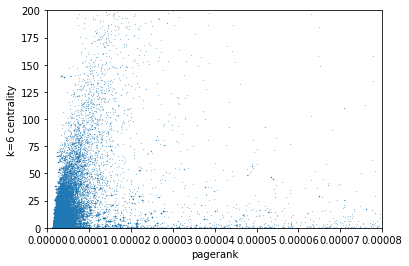

In [443]:
plt.scatter(df_new["pagerank"], 
            k_centralities[-1],
            marker=".", s=0.1)

plt.xlim((0, .0012/15))
plt.ylim((0, 200))
plt.xlabel("pagerank")
plt.ylabel("k=6 centrality")

Calculate correlation coefficients for different values of k

In [516]:
for i in range(10):
    print(f"k={i}: ", np.corrcoef(df_new["pagerank"], k_centralities[i])[0][1])


k=0:  1.2402179197971935e-16
k=1:  0.8981360551401599
k=2:  0.3480092401743838
k=3:  0.7659265444675852
k=4:  0.394697522993601
k=5:  0.7269703757174957
k=6:  0.42128879089960825
k=7:  0.7017763622232374
k=8:  0.4419773410391871
k=9:  0.6734977781536141
